In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm


from rsq import AgglomerativeEnsemble

from joblib import Parallel, delayed

import torchvision

import pickle

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def few_shot_sample(y, n_samples_per_class=1):
    unique_y = np.unique(y)    
    inds = [np.random.choice(np.where(y == c)[0], size=n_samples_per_class, replace=False) for c in unique_y]
    
    return np.concatenate(inds)

In [2]:
from genieclust import Genie

In [3]:
#- Data processing 1

class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            self.data = pickle.load(open(file, 'rb'))[0][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            self.data = pickle.load(open(file, 'rb'))[1][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [4]:
#- Data processing 2
# cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

file='/home/hhelm/data/cifar_100_Bit_m-r101x1_embd.p'


trainset = Dataset(file, train=True, classes=[])
X = trainset.data
y = trainset.targets

testset = Dataset(file, train=False, classes=[])
X_test = testset.data
y_test = testset.targets

del trainset, testset

In [5]:
def benchmark_agg_class(X, y, inds_sup, kwargs):
    y_ = -1 * np.ones(len(y))
    y_[inds_sup] = y[inds_sup]
    
    agg_class = AgglomerativeEnsemble(**kwargs)
    fit_time_ = time()
    agg_class.fit(X, y_)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    accuracy = (agg_class.predict(X_test) == y_test).mean()
    inf_time = time() - inf_time_
    
    print(accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark = lambda x: benchmark_agg_class(*x)

In [6]:
%load_ext autoreload

In [ ]:
np.random.seed(1)
import copy



n_neighbors_list = [1, 2,4,8,16,32,64]
kwargs = {'n_estimators':180, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': 512}, 
          'affinity':'cosine', 'linkage':'average',
          'max_tree_distance':400, 'n_jobs':30}

n_cores=1
# n_mc=int(n_cores / len(prop_labeled))
n_mc=10

experiment_tuples = []
for i, n_neighbors in enumerate(n_neighbors_list):
    for _ in range(n_mc):
        temp_kwargs = copy.deepcopy(kwargs)
        temp_kwargs['n_neighbors'] = n_neighbors
        
        all_inds = stratified_sample(y, p=0.5, replace=False)
        inds_sup = few_shot_sample(y[all_inds])
        experiment_tuples.append((X[all_inds], y[all_inds], inds_sup, temp_kwargs))
    
start_time = time()
try:
    results_p_unlabeled = Parallel(n_jobs=1)(delayed(benchmark)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

0.4209 350.2749798297882 60.84224772453308
0.3877 357.95550656318665 61.516557455062866
0.3796 361.26105093955994 62.2988805770874
0.387 355.16170477867126 61.437841176986694
0.3815 355.20537066459656 60.12126183509827
0.3895 356.62959480285645 59.41148495674133
0.3994 366.3004357814789 60.62957286834717
0.4093 372.4794137477875 62.04636287689209
0.3859 363.38510274887085 61.3030800819397
0.4096 355.2924852371216 60.34713935852051


In [ ]:
time_ =time()
gen = Genie(n_clusters=2,
    gini_threshold=0.3,
    M=1,
    affinity='l2',
    exact=False,
    compute_full_tree=False,
    compute_all_cuts=False,
    postprocess='boundary',
    cast_float32=True,
    mlpack_enabled='auto',
    mlpack_leaf_size=1,
    nmslib_n_neighbors=64,
    nmslib_params_init={'method': 'hnsw'},
    nmslib_params_index={'post': 2},
    nmslib_params_query={}).fit(X[all_inds])
print(time() - time_)

In [8]:
dist = 1 - X[all_inds] @ X[all_inds].T
np.fill_diagonal(dist, 0)

In [ ]:
time_ = time()
gen = Genie(n_clusters=2,
    gini_threshold=0.3,
    M=1,
    affinity='l2',
    exact=True,
    compute_full_tree=True,
    compute_all_cuts=False,
    postprocess='boundary',
    cast_float32=True,
    mlpack_enabled='auto',
    mlpack_leaf_size=1,
    nmslib_n_neighbors=64,
    nmslib_params_init={'method': 'hnsw'},
    nmslib_params_index={'post': 2},
    nmslib_params_query={}).fit(X[all_inds])
print(time() - time_)

In [10]:
from rsq import AgglomerativeClassifier

y_ = -1 * np.ones(len(all_inds))
y_[inds_sup] = y[all_inds][inds_sup]

time_=time()
AgglomerativeClassifier(linkage='average', n_neighbors_connectivity=64).fit(X[all_inds], y_)
print(time() - time_)

13.039578914642334


In [34]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=len(all_inds)-1).fit(X[all_inds])

In [33]:
nn.kneighbors_graph()

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5000, n_neighbors = 5001

In [16]:
from sklearn.cluster import AgglomerativeClustering

time_=time()
clusters = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='average').fit_predict(X[all_inds])
print(time() - time_)
print(clusters)

16.54620337486267
[55 15 15 ... 47 47 12]


In [17]:
time_=time()
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(X[all_inds], metric='euclidean')
clusters_precomp = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='average').fit_predict(dist)
print(time() - time_)
print(clusters_precomp)

1.57228684425354
[55 15 15 ... 47 47 12]


In [18]:
(clusters == clusters_precomp).mean()

1.0

In [31]:
from sklearn.cluster import AgglomerativeClustering

time_=time()
clusters = AgglomerativeClustering(affinity='cosine', linkage='average').fit(X[all_inds])
print(time() - time_)

15.371596574783325


In [32]:
from sklearn.metrics import pairwise_distances

time_=time()
dist = pairwise_distances(X[all_inds], metric='cosine')
clusters= AgglomerativeClustering(affinity='precomputed', linkage='average').fit(dist)
print(time() - time_)

0.8454024791717529


In [ ]:
np.random.seed(123)
model_p = AgglomerativeClustering(
  n_clusters          = 100,
  affinity            = 'precomputed',
  linkage             = 'average',
  compute_full_tree   = True,
)

t    = time()
dist = 1 - X @ X.T
np.fill_diagonal(dist, 0)

a = model_p.fit_predict(dist)
a_time = time() - t

# --

np.random.seed(123)
model_c = AgglomerativeClustering(
  n_clusters          = 100,
  affinity            = 'cosine',
  linkage             = 'average',
  compute_full_tree   = True,
)

t = time()
b = model_c.fit_predict(X)
b_time = time() - t

assert (a == b).all()
# passes

print(b_time, a_time)
# 14.483706951141357 0.9161789417266846
print(b_time / a_time)

In [ ]:
accuracies = np.zeros((len(n_neighbors_list), n_mc))
fit_times = np.zeros((len(n_neighbors_list), n_mc))
inf_times = np.zeros((len(n_neighbors_list), n_mc))

for i, triple in enumerate(results_p_unlabeled):
    for j in range(n_mc):
        accuracies[int(np.math.floor(i/n_mc)), j] = triple[0]
        fit_times[int(np.math.floor(i/n_mc)), j] = triple[1]
        inf_times[int(np.math.floor(i/n_mc)), j] = triple[2]

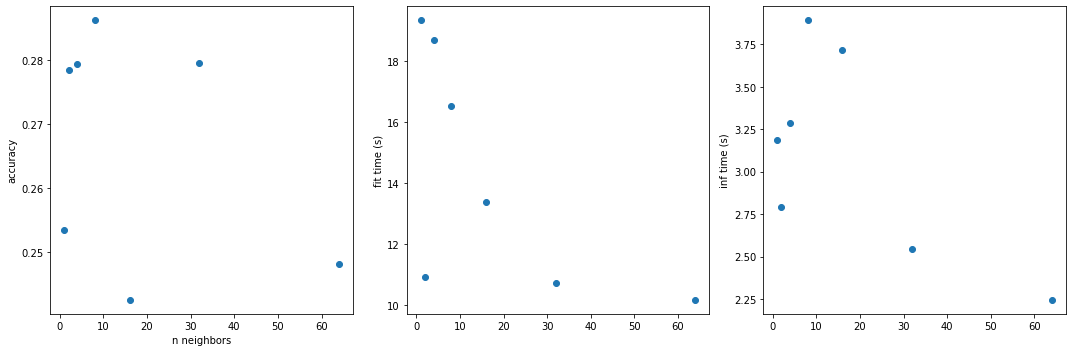

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

for ax_ in ax:
    ax_.set_xscale('linear')

ax[0].scatter(n_neighbors_list, np.mean(accuracies, axis=-1))
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('n neighbors')

# fig, ax = plt.subplots(1,3)
ax[1].scatter(n_neighbors_list, np.mean(fit_times, axis=-1))
ax[1].set_ylabel('fit time (s)')
# ax[1].set_xlabel('proportion o')

# fig, ax = plt.subplots(1,3)
ax[2].scatter(n_neighbors_list, np.mean(inf_times, axis=-1))
ax[2].set_ylabel('inf time (s)')
# ax[2].set_xlabel('proportion of')

plt.tight_layout()